# Dataset Download & Visualization

Download the private dataset using below link

https://www.kaggle.com/datasets/msambare/fer2013?resource=download

> Dataset will be placed in directory dataset > {paste here}


Train set: (Total images: 28709)
  Angry: 3995 images
  Disgust: 436 images
  Fear: 4097 images
  Happy: 7215 images
  Neutral: 4965 images
  Sad: 4830 images
  Surprise: 3171 images

Test set: (Total images: 7178)
  Angry: 958 images
  Disgust: 111 images
  Fear: 1024 images
  Happy: 1774 images
  Neutral: 1233 images
  Sad: 1247 images
  Surprise: 831 images


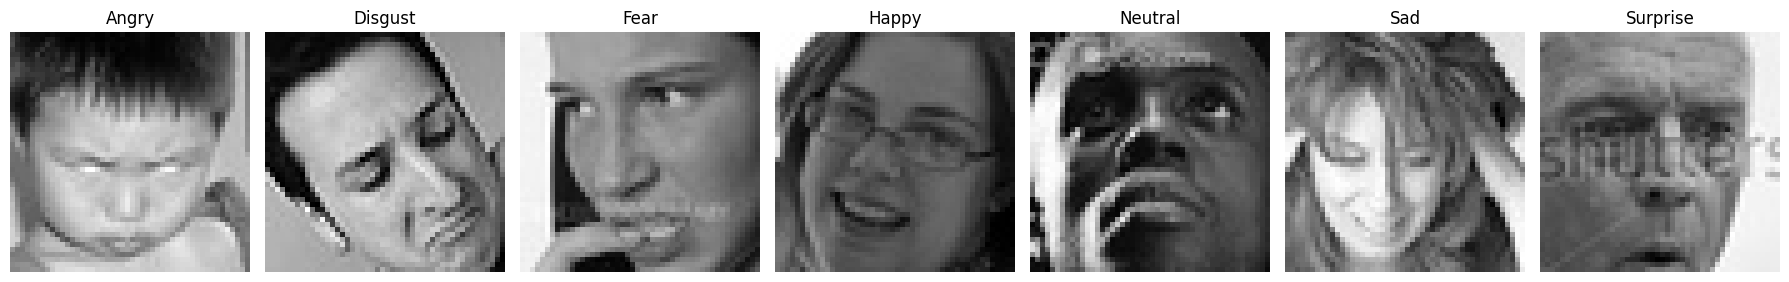

In [2]:
import os
import cv2
import matplotlib.pyplot as plt

# Emotion labels in FER2013 dataset
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Set dataset root path
dataset_root = "./dataset"

# Count images
def count_images(directory):
    counts = {}
    for emotion in emotions:
        emotion_dir = os.path.join(directory, emotion)
        if os.path.exists(emotion_dir):
            counts[emotion] = len(os.listdir(emotion_dir))
        else:
            counts[emotion] = 0
    return counts

# Print counts for train and test images
for folder in ["train", "test"]:
    folder_path = os.path.join(dataset_root, folder)
    counts = count_images(folder_path)
    print(f"\n{folder.capitalize()} set: (Total images: {sum(counts.values())})")
    for emotion in emotions:
        print(f"  {emotion.capitalize()}: {counts[emotion]} images")

# Grid View plotting function
def visualize_grid(directory):
    plt.figure(figsize=(18, 4))
    for idx, emotion in enumerate(emotions):
        class_dir = os.path.join(directory, emotion)
        img_names = os.listdir(class_dir)
        if not img_names:
            continue
        img_path = os.path.join(class_dir, img_names[0])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        plt.subplot(1, len(emotions), idx + 1)
        plt.imshow(img, cmap='gray')
        plt.title(emotion.capitalize())
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize from train set
visualize_grid(os.path.join(dataset_root, "train"))


## Data Preprocessing

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.utils.class_weight import compute_class_weight
import os

# Emotion labels
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
dataset_root = "./dataset"
img_size = (224, 224)

# Preprocessing function for ImageNet
def preprocess_image(img):
    # Image is loaded as RGB; convert to grayscale and back to RGB for consistency
    if img.shape[-1] == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = np.expand_dims(img_gray, axis=-1)  # Shape: (224, 224, 1)
        img = np.repeat(img, 3, axis=-1)  # Shape: (224, 224, 3)
    return preprocess_input(img)  # Normalize pixel values to [-1, 1] with ImageNet mean subtraction

# Compute class weights for imbalance
def get_class_weights():
    train_counts = {
        "angry": 3995, "disgust": 436, "fear": 4097, "happy": 7215,
        "neutral": 4965, "sad": 4830, "surprise": 3171
    }
    labels = []
    for idx, emotion in enumerate(emotions):
        labels.extend([idx] * train_counts[emotion])
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(labels),
        y=labels
    )
    return dict(enumerate(class_weights))

# Create data generators with 80/20 split
def create_data_generators():
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_image,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        os.path.join(dataset_root, "train"),
        target_size=img_size,
        color_mode="rgb",  # Load as RGB for MobileNetV2
        batch_size=64,
        class_mode="categorical",
        classes=emotions,
        subset="training"
    )
    validation_generator = train_datagen.flow_from_directory(
        os.path.join(dataset_root, "train"),
        target_size=img_size,
        color_mode="rgb",  # Load as RGB
        batch_size=64,
        class_mode="categorical",
        classes=emotions,
        subset="validation"
    )
    test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_image
    )
    test_generator = test_datagen.flow_from_directory(
        os.path.join(dataset_root, "test"),
        target_size=img_size,
        color_mode="rgb",  # Load as RGB
        batch_size=64,
        class_mode="categorical",
        classes=emotions
    )
    return train_generator, validation_generator, test_generator

# Execute preprocessing
train_gen, val_gen, test_gen = create_data_generators()
class_weights = get_class_weights()
print("Class weights:", class_weights)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class weights: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


## MobileNetv2 Model

In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Build model
def build_model():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights="imagenet" 
    )
    # Freeze base model layers
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(emotions), activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# Create model
model = build_model()

9406464/9406464 [==============================] - 0s 0us/step


# Training the Model

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def train_model(model, train_generator, validation_generator, class_weights):
    # Define callbacks
    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
        verbose=1
    )
    checkpoint = ModelCheckpoint(
        "best_emotion_model.h5",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    )

    # Train model
    model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        steps_per_epoch=train_generator.samples // 64,
        validation_steps=validation_generator.samples // 64,
        class_weight=class_weights,
        callbacks=[early_stopping, checkpoint]
    )
    return model

# Execute training
model = train_model(model, train_gen, val_gen, class_weights)

Epoch 1/10
358/358 [==============================] - ETA: 0s - loss: 1.8666 - accuracy: 0.2400
Epoch 1: val_accuracy improved from -inf to 0.26246, saving model to best_emotion_model.h5
358/358 [==============================] - 411s 1s/step - loss: 1.8666 - accuracy: 0.2400 - val_loss: 1.7886 - val_accuracy: 0.2625
Epoch 2/10
358/358 [==============================] - ETA: 0s - loss: 1.7685 - accuracy: 0.2828
Epoch 2: val_accuracy improved from 0.26246 to 0.34164, saving model to best_emotion_model.h5
358/358 [==============================] - 285s 797ms/step - loss: 1.7685 - accuracy: 0.2828 - val_loss: 1.6719 - val_accuracy: 0.3416
Epoch 3/10
358/358 [==============================] - ETA: 0s - loss: 1.7256 - accuracy: 0.3066
Epoch 3: val_accuracy improved from 0.34164 to 0.37728, saving model to best_emotion_model.h5
358/358 [==============================] - 286s 797ms/step - loss: 1.7256 - accuracy: 0.3066 - val_loss: 1.6254 - val_accuracy: 0.3773
Epoch 4/10
358/358 [===========

# Evaluation

Found 7178 images belonging to 7 classes.
112/112 [==============================] - 77s 689ms/step - loss: 1.5683 - accuracy: 0.3977
Test Loss: 1.5683
Test Accuracy: 0.3977
113/113 [==============================] - 65s 576ms/step


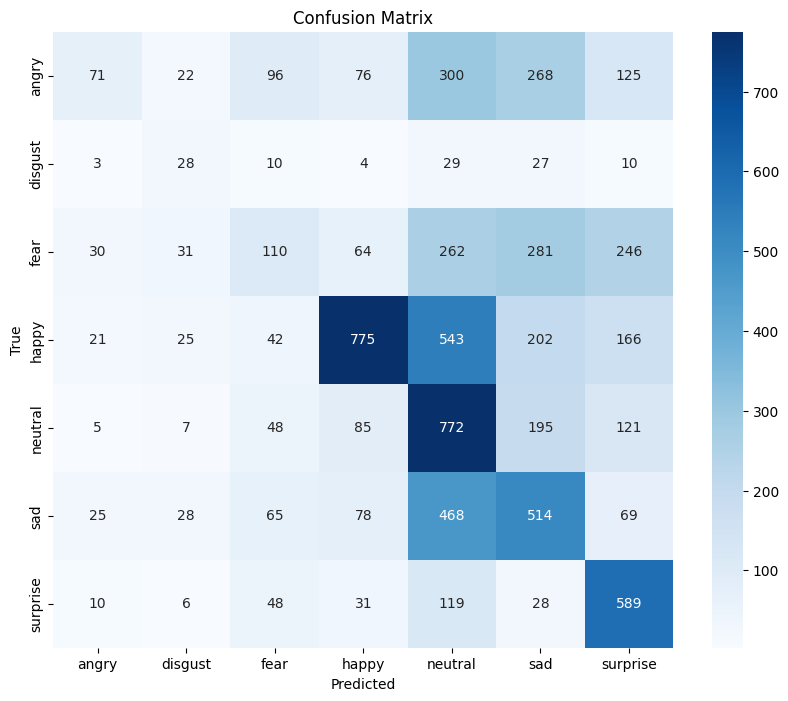


Classification Report:
              precision    recall  f1-score   support

       angry       0.43      0.07      0.13       958
     disgust       0.19      0.25      0.22       111
        fear       0.26      0.11      0.15      1024
       happy       0.70      0.44      0.54      1774
     neutral       0.31      0.63      0.41      1233
         sad       0.34      0.41      0.37      1247
    surprise       0.44      0.71      0.55       831

    accuracy                           0.40      7178
   macro avg       0.38      0.37      0.34      7178
weighted avg       0.43      0.40      0.37      7178



In [2]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Emotion labels
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
dataset_root = "./dataset"
img_size = (224, 224)

# Preprocessing function
def preprocess_image(img):
    if img.shape[-1] == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = np.expand_dims(img_gray, axis=-1)
        img = np.repeat(img, 3, axis=-1)
    return preprocess_input(img)

# Create test data generator
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_root, "test"),
    target_size=img_size,
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    classes=emotions,
    shuffle=False
)

# Load the trained model
model = load_model("best_emotion_model.h5")

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // 64)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
test_generator.reset()
y_pred = model.predict(test_generator, steps=test_generator.samples // 64 + 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes[:len(y_pred_classes)]

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotions, yticklabels=emotions)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confusion_matrix.png")
plt.show()

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=emotions))

# Save classification report to file
with open("classification_report.txt", "w") as f:
    f.write(classification_report(y_true, y_pred_classes, target_names=emotions))

# Main

In [3]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import pandas as pd
from datetime import datetime
import os

# Emotion labels
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
img_size = (224, 224)

# Load the trained model
model = load_model("best_emotion_model.h5")

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
if face_cascade.empty():
    raise Exception("Error loading Haar Cascade classifier")

# Initialize webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise Exception("Error opening webcam")

# Initialize emotion log
log_data = {"timestamp": [], "emotion": [], "confidence": []}
os.makedirs("logs", exist_ok=True)

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame")
            break

        # Convert frame to grayscale for face detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        for (x, y, w, h) in faces:
            # Extract face ROI
            face = frame[y:y+h, x:x+w]
            # Resize and preprocess for model
            face_resized = cv2.resize(face, img_size)
            face_array = np.expand_dims(face_resized, axis=0)
            face_array = preprocess_input(face_array)

            # Predict emotion
            pred = model.predict(face_array, verbose=0)
            emotion_idx = np.argmax(pred[0])
            emotion = emotions[emotion_idx]
            confidence = pred[0][emotion_idx]

            # Draw bounding box and label
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            label = f"{emotion}: {confidence:.2f}"
            cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

            # Log emotion
            log_data["timestamp"].append(datetime.now())
            log_data["emotion"].append(emotion)
            log_data["confidence"].append(confidence)

        # Display frame
        cv2.imshow("EmoTrack - Real-Time Emotion Detection", frame)

        # Save log periodically
        if len(log_data["timestamp"]) >= 100:
            df = pd.DataFrame(log_data)
            df.to_csv(f"logs/emotion_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv", index=False)
            log_data = {"timestamp": [], "emotion": [], "confidence": []}

        # Exit on 'q' key
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

finally:
    # Save remaining log
    if log_data["timestamp"]:
        df = pd.DataFrame(log_data)
        df.to_csv(f"logs/emotion_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv", index=False)

    # Cleanup
    cap.release()
    cv2.destroyAllWindows()